<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/pixel_level_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to import segmentation pre-annotations

In this tutorial, we will show you how to import prediction labels into your Kili project.

You will see these predictions as pre-annotations in your labeling interface, and you will be able to modify or validate them.

We will discover this feature on a [segmentation project](https://docs.kili-technology.com/docs/semantic-segmentation) that is used to work with images or videos with pixel-level annotations.

The data used in this tutorial is from the [COCO dataset](http://cocodataset.org/#explore?id=219921).

## Import an image into your Kili project

Let's first inspect what our annotated image looks like in the COCO dataset.

Raw image             |  With the annotations
:-------------------------:|:-------------------------:
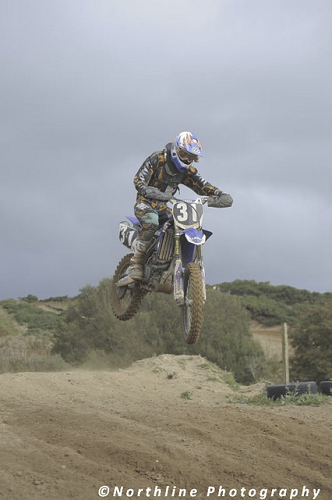 | 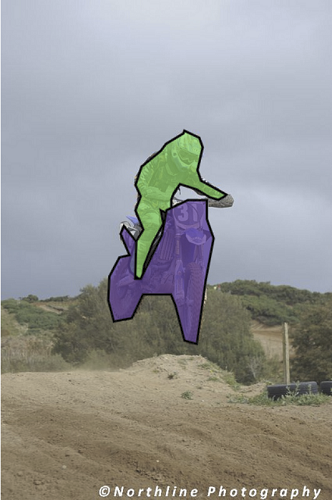

Before starting, we install the requirements:

In [ ]:
%pip install matplotlib Pillow kili opencv-python

In [ ]:
%matplotlib inline

import functools
import json
import os
import time
import urllib.request
from random import randint

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image

from kili.client import Kili

Let's authenticate to Kili:

In [ ]:
kili = Kili(
    # api_endpoint="https://cloud.kili-technology.com/api/label/v2/graphql",
    # the line above can be uncommented and changed if you are working with an on-premise version of Kili
)

Let's create an image project in Kili where we can annotate images with a `semantic` tool and two classes: `HUMAN` and `MOTORCYCLE` at pixel level.

We create the image project with its ontology (json_interface):

In [ ]:
json_interface = {
    "jobs": {
        "JOB_0": {
            "mlTask": "OBJECT_DETECTION",
            "tools": ["semantic"],
            "instruction": None,
            "required": 1,
            "isChild": False,
            "content": {
                "categories": {
                    "MOTORCYCLE": {"name": "Motorcycle", "children": [], "color": "#0755FF"},
                    "HUMAN": {"name": "Human", "children": [], "color": "#EEBA00"},
                },
                "input": "radio",
            },
        }
    }
}

In [ ]:
project = kili.create_project(
    description="COCO dataset",
    input_type="IMAGE",
    json_interface=json_interface,
    title="[Kili SDK Notebook]: Motorcycle annotation segmentation project",
)

project_id = project["id"]

Then, we upload the image to the project:

In [ ]:
external_id = "moto"
content = "https://farm7.staticflickr.com/6153/6181981748_6a225c275d_z.jpg"

kili.append_many_to_dataset(
    project_id=project_id,
    content_array=[content],
    external_id_array=[external_id],
    json_content_array=None,
);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


You should now be able to visualize your asset in Kili:

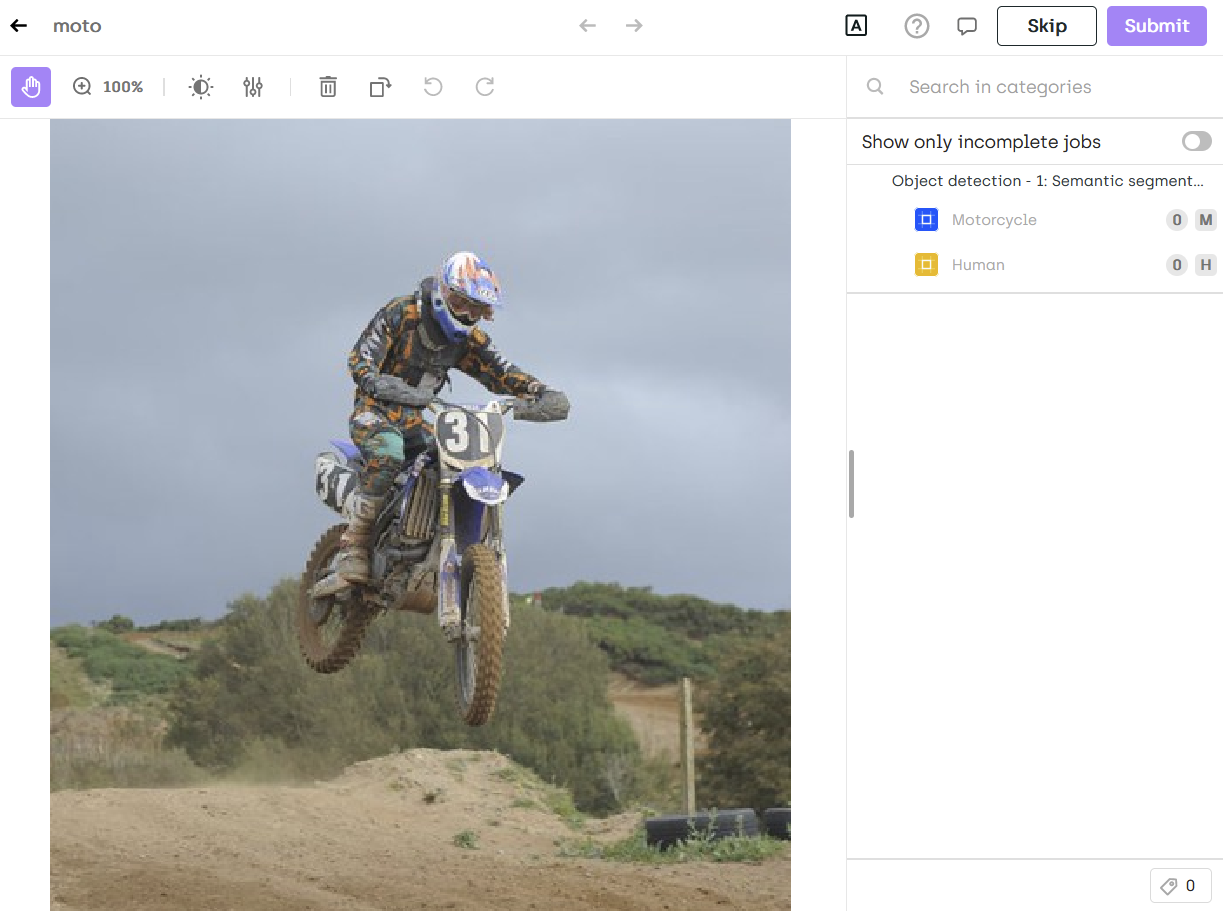

## Import annotations from a mask

Now, imagine you already have your annotation stored as a mask. You want to insert it in Kili Technology as a [prediction](https://docs.kili-technology.com/recipes/importing-labels-and-predictions). Here is what the mask looks like:

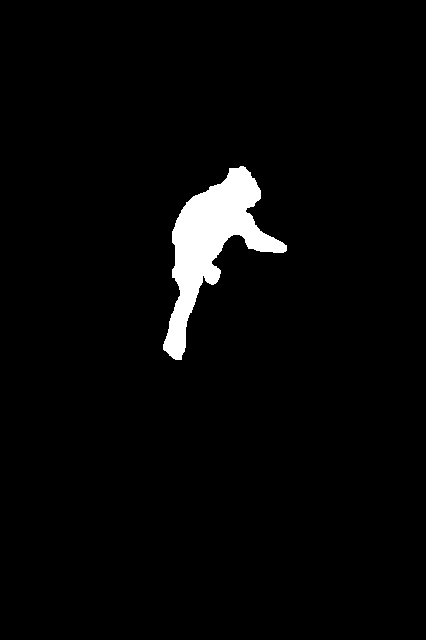

We can start by downloading the image on disk:

In [ ]:
mask_url = "https://raw.githubusercontent.com/kili-technology/kili-python-sdk/main/recipes/img/HUMAN.mask.png"
urllib.request.urlretrieve(mask_url, "mask.png");

Kili SDK provides a set of utils to easily create labels. See the [documentation](https://python-sdk-docs.kili-technology.com/latest/sdk/label_utils/) for more information.

Now, we will use the `mask_to_normalized_vertices` helper method to create a segmentation label from the mask image.

In [ ]:
from kili.utils.labels.image import mask_to_normalized_vertices

In [ ]:
mask = cv2.imread("mask.png")[:, :, 0]
contours, _ = mask_to_normalized_vertices(mask)
print(f"Found {len(contours)} contour(s) in the mask.")

Found 1 contour(s) in the mask.


In [ ]:
annotations = [
    {
        "boundingPoly": [{"normalizedVertices": contour} for contour in contours],
        "categories": [{"name": "HUMAN", "confidence": 100}],
        "mid": randint(100, 1000),
        "score": None,
        "type": "polygon",
    }
]
json_response = {"JOB_0": {"annotations": annotations}}

In [ ]:
kili.create_predictions(
    project_id=project_id,
    external_id_array=[external_id],
    json_response_array=[json_response],
    model_name="original_mask",
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


{'id': 'clfql5ikf01zz0jsxaxohccnx'}

That's it! Your mask was just converted to Kili Technology's standard format and uploaded as a prediction to the platform:

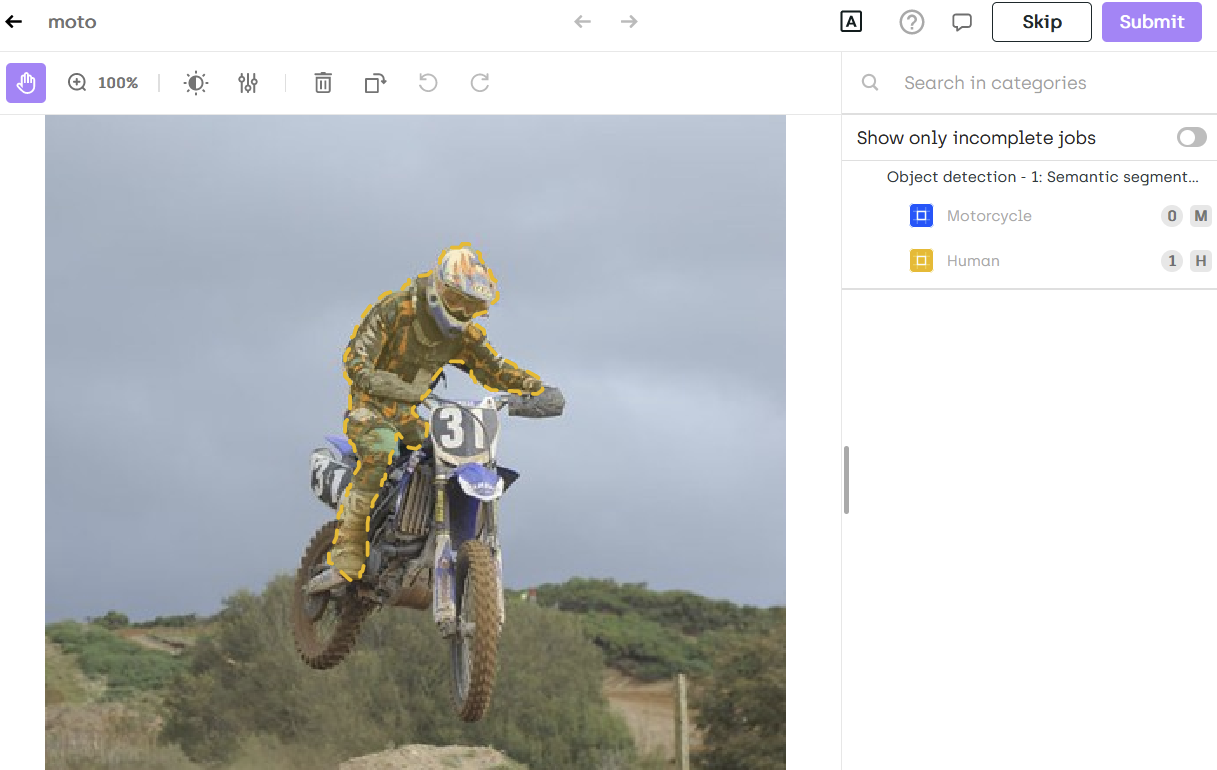

## Export the annotations as a mask

You may want to do the reverse operation, that is download the existing annotation from Kili and convert it to a mask.

Let's see how you can achieve this using the helper method `normalized_vertices_to_mask`!

In [ ]:
from kili.utils.labels.image import normalized_vertices_to_mask

Then, we can retrieve the json response and plot the mask:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


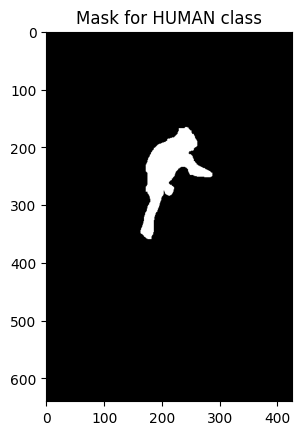

In [ ]:
labels = kili.labels(
    project_id=project_id, asset_external_id_in=[external_id], fields=["jsonResponse"]
)
label = labels[0]
json_response = label["jsonResponse"]
reconstructed_mask = normalized_vertices_to_mask(
    json_response["JOB_0"]["annotations"][0]["boundingPoly"][0]["normalizedVertices"],
    mask.shape[1],
    mask.shape[0],
)

plt.title(f"Mask for HUMAN class")
plt.imshow(reconstructed_mask, cmap="gray")
plt.show()

## Cleanup

We can remove the project that we created:

In [ ]:
kili.delete_project(project_id)

## Conclusion

You can now try uploading your own predictions using `kili.create_predictions()`!